#### Objective:  Perform Named Entity Recognition (NER) for place names in textual data, identify spatial entities and geocode them to eventually plot them on a world map.

##### Step 1: Load required libraries/ modeules

In [1]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [2]:
# !pip install SPARQLWrapper

In [3]:
# import packages
import wikipedia
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import seaborn as sns
import contextily as ctx
# import spacy-dbpedia-spotlight  as sds
import geopy
from matplotlib import pyplot as plt
import spacy
import warnings
warnings.filterwarnings("ignore")

In [4]:
from SPARQLWrapper import SPARQLWrapper, JSON

##### Step 2: Select any 20 Wikipedia articles

In [5]:
# Set the language to English (or your desired language)
wikipedia.set_lang("en")

# Perform a search for articles containing 'mangroves'
search_results = wikipedia.search("mangroves", results=20)

# Collect the articles and their titles
articles = []

for title in search_results:
    try:
        article = wikipedia.page(title)
        articles.append(article)
        content = wikipedia.page(title).content
        articles.append(content)
    except wikipedia.exceptions.DisambiguationError as e:
        # Handle disambiguation pages, if necessary
        print(f"Disambiguation page: {e.options}")

# Print the titles of the collected articles
for article in articles:
    print(article.title)
    #print(article.content)


Mangrove
<built-in method title of str object at 0x0000016B3BF66900>
Mangrove forest
<built-in method title of str object at 0x0000016B3BF4A5E0>
Sundarbans
<built-in method title of str object at 0x0000016B3BF960C0>
Pichavaram
<built-in method title of str object at 0x0000016B39E5FB50>
Florida mangroves
<built-in method title of str object at 0x0000016B3BEE1040>
Mangrove restoration
<built-in method title of str object at 0x0000016B3BF59A80>
Godavari–Krishna mangroves
<built-in method title of str object at 0x0000016B3BF488D0>
Bhitarkanika Mangroves
<built-in method title of str object at 0x0000016B36E76390>
Niger Delta mangroves
<built-in method title of str object at 0x0000016B3BFF11F0>
Greater Antilles mangroves
<built-in method title of str object at 0x0000016B3BEF5FF0>
Australian mangroves
<built-in method title of str object at 0x0000016B3A2C11B0>
Mangrove tree distribution
<built-in method title of str object at 0x0000016B3BFA9890>
Belizean reef mangroves
<built-in method title 

In [6]:
# Set the language to English (or your desired language)
wikipedia.set_lang("en")

# Perform a search for articles containing 'mangroves'
search_results = wikipedia.search("mangroves", results=20)

# Collect the articles and their titles
articles = []

for title in search_results:
    try:
        page = wikipedia.page(title)
        articles.append(page.content)
        
    except wikipedia.exceptions.DisambiguationError as e:
        # Handle disambiguation pages, if necessary
        print(f"Disambiguation page: {e.options}")

# Print the titles of the collected articles
for article in articles:
    print(article)
    #print(article.content)

A mangrove is a shrub or tree that grows mainly in coastal saline or brackish water.  Mangroves grow in an equatorial climate, typically along coastlines and tidal rivers. They have special adaptations to take in extra oxygen and to remove salt, which allow them to tolerate conditions that would kill most plants. The term is also used for tropical coastal vegetation consisting of such species. Mangroves are taxonomically diverse, as a result of convergent evolution in several plant families. They occur worldwide in the tropics and subtropics and even some temperate coastal areas, mainly between latitudes 30° N and 30° S, with the greatest mangrove area within 5° of the equator. Mangrove plant families first appeared during the Late Cretaceous to Paleocene epochs, and became widely distributed in part due to the movement of tectonic plates. The oldest known fossils of mangrove palm date to 75 million years ago.
Mangroves are salt-tolerant trees, shrubs and ferns also called halophytes, 

##### Step 3: Setup and run a NER for place name and extract location names

In [7]:
# Load the English language model for spaCy
nlp = spacy.load("en_core_web_sm")

# Create a list to store location names
location_names = []

for article_content in articles:
    # Process the text content with spaCy
    doc = nlp(article_content)

    # Extract location names (entities labeled as 'GPE' in spaCy)
    for ent in doc.ents:
        if ent.label_ == 'GPE':
            location_names.append(ent.text)

# Print the extracted location names
for location in location_names:
    print(location)


manggi
Avicennia
Avicennia
Bruguiera
Avicennia
Ceriops
Bruguiera
Taxonomy
Japan
South Africa
New Zealand
Victoria
Australia
Avicennia
Victoria
Australia
New Zealand
Avicennia
Australia
Avicennia
Florida
St. Augustine
Japan
Kandelia
al.
Vietnam
Thailand
Philippines
India
Puerto Rico
Puerto Rico
Proteobacteria
Deltaproteobacteria
Alphaproteobacteria
Alteromonadales
Desulfuromonadales
Desulfovibrionales
mangrove
Cambridge
The Hague
Koedam
Sri Lanka
Agrawala
Ota
Tomoko
Risbey
Smith
Fiji
Development
Paris
France
Sathirathai
Bosire
Koedam
Valiela
Ivan
York
Bluemel
Venezuela
j.ecolind.2012.04.022
Spalding
Kainuma
London
Alemán
Bourgeois
De Hauwere
Quoc
Oppelt
Queensland
Queensland
Bacteria
Ecuador
Bangladesh
Puerto Rico
Mangalavanam
Pichavaram
Macrofauna
Biogeochemistry
Australia
Thailand
Madagascar
Madagascar
Bahamas
Trinidad
Tobago
Ecuador
Naluvedapathy
Japan
Arkiko
Eritrea
Java
Indonesia
Netherlands
Demak
Belize
Belize
Belize
Belize
Belize City
Belize
Belize
Belize
Belize
Belize
Tanzania
T

##### Step 4: Geocode all entities and extract coordinates

In [8]:
# this function is from online resources as other methods (including Nominatum) gave Error geocoding
def geocode_locations(location_names):
    results = {}

    # Set the SPARQL endpoint URL
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")

    for location in location_names:
        # Define the SPARQL query to retrieve coordinates for the location
        query = f"""
        PREFIX dbo: <http://dbpedia.org/ontology/>
        PREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>

        SELECT ?lat ?long
        WHERE {{
          ?place a dbo:Place ;
                 rdfs:label "{location}"@en ;
                 geo:lat ?lat ;
                 geo:long ?long .
        }}
        """

        # Set the query and request format
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)

        # Execute the query and retrieve the results
        query_results = sparql.query().convert()

        if "results" in query_results and "bindings" in query_results["results"]:
            bindings = query_results["results"]["bindings"]
            if bindings:
                # Extract coordinates
                lat = float(bindings[0]["lat"]["value"]) if "lat" in bindings[0] else None
                long = float(bindings[0]["long"]["value"]) if "long" in bindings[0] else None
                results[location] = (lat, long)

    return results


In [9]:
coordinates = geocode_locations(location_names)

# Print the extracted coordinates
for location, (lat, long) in coordinates.items():
    print(f"Location: {location}")
    print(f"Latitude: {lat}")
    print(f"Longitude: {long}")


Location: Japan
Latitude: 35.6833
Longitude: 139.767
Location: South Africa
Latitude: -30.0
Longitude: 25.0
Location: New Zealand
Latitude: -41.3
Longitude: 174.783
Location: Australia
Latitude: -35.3081
Longitude: 149.124
Location: Florida
Latitude: 28.0
Longitude: -82.0
Location: Vietnam
Latitude: 16.0
Longitude: 105.85
Location: Thailand
Latitude: 13.75
Longitude: 100.483
Location: Philippines
Latitude: 13.0
Longitude: 122.0
Location: India
Latitude: 28.6139
Longitude: 77.2083
Location: Cambridge
Latitude: 52.2053
Longitude: 0.119167
Location: The Hague
Latitude: 52.08
Longitude: 4.31
Location: Sri Lanka
Latitude: 6.93333
Longitude: 79.8667
Location: Fiji
Latitude: -18.1667
Longitude: 178.45
Location: Paris
Latitude: 48.8566
Longitude: 2.35222
Location: France
Latitude: 47.0
Longitude: 2.0
Location: York
Latitude: 53.9601
Longitude: -1.07802
Location: Venezuela
Latitude: 7.0
Longitude: -66.9167
Location: London
Latitude: 51.5072
Longitude: -0.1275
Location: Ecuador
Latitude: -2.0
Lo

##### Step 5: Plot it

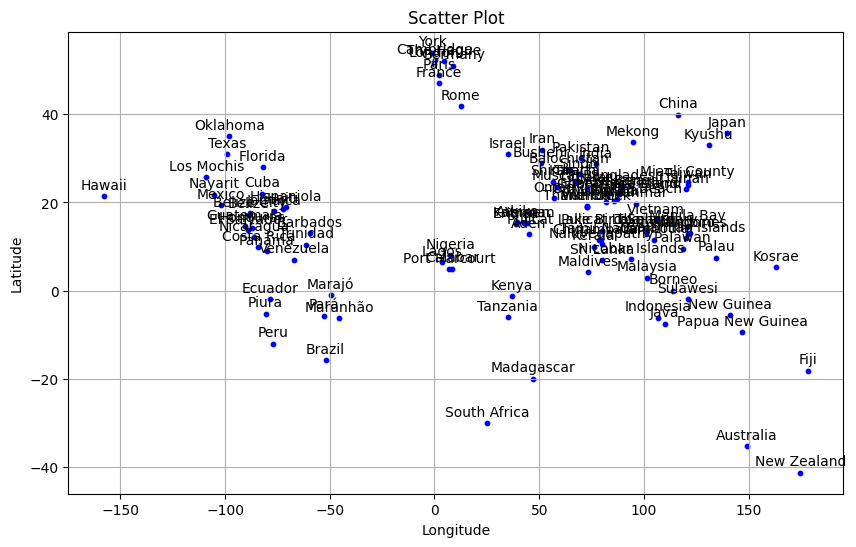

In [10]:
# Extract coordinates from the dictionary
location_names = list(coordinates.keys())
coords = list(coordinates.values())
latitudes, longitudes = zip(*coords)

# Create a scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.scatter(longitudes, latitudes, c='blue', marker='o', s=10)  # Adjust colors, markers, and marker sizes as needed

# Add labels for each point (location name)
for i, name in enumerate(coordinates):
    plt.annotate(name, (longitudes[i], latitudes[i]), textcoords="offset points", xytext=(0,5), ha='center')

# Customize plot labels, title, and axis labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot')
plt.grid()

# Show the plot
plt.show()


##### Step 6: Plot on world map

In [11]:
# Create a DataFrame from the extracted data
locations_df = pd.DataFrame({'LocationName': location_names, 'Latitude': latitudes, 'Longitude': longitudes})

# Create a Point geometry column from the latitude and longitude
geometry = [Point(lon, lat) for lon, lat in zip(locations_df['Longitude'], locations_df['Latitude'])]

# Create a GeoDataFrame
gdf = GeoDataFrame(locations_df, geometry=geometry)

# Display the GeoDataFrame
gdf

,LocationName,Latitude,Longitude,geometry
0,Japan,35.683300,139.7670,POINT (139.76700 35.68330)
1,South Africa,-30.000000,25.0000,POINT (25.00000 -30.00000)
2,New Zealand,-41.300000,174.7830,POINT (174.78300 -41.30000)
3,Australia,-35.308100,149.1240,POINT (149.12400 -35.30810)
4,Florida,28.000000,-82.0000,POINT (-82.00000 28.00000)
...,...,...,...,...
107,Marajó,-0.983333,-49.5833,POINT (-49.58330 -0.98333)
108,Mekong,33.708300,94.6950,POINT (94.69500 33.70830)
109,Pattaya,12.935700,100.8890,POINT (100.88900 12.93570)
110,Los Mochis,25.783500,-108.9940,POINT (-108.99400 25.78350)


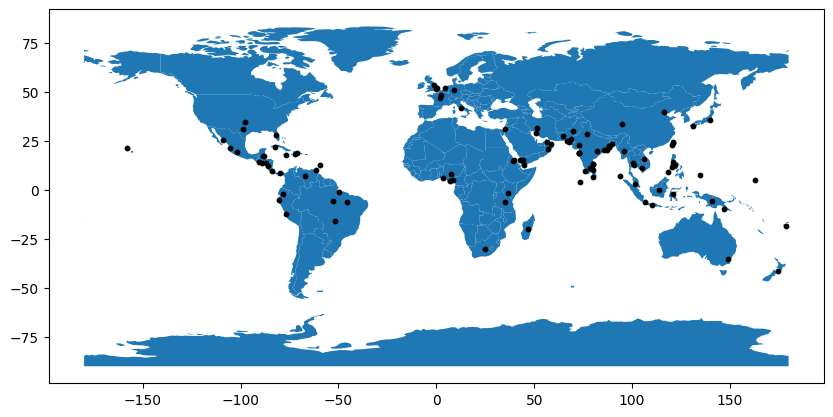

In [12]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax = world.plot(figsize=(10,6)), marker='o',color='black',markersize=10);

##### Step 7: Kernel Density Estimations on the spatial locations

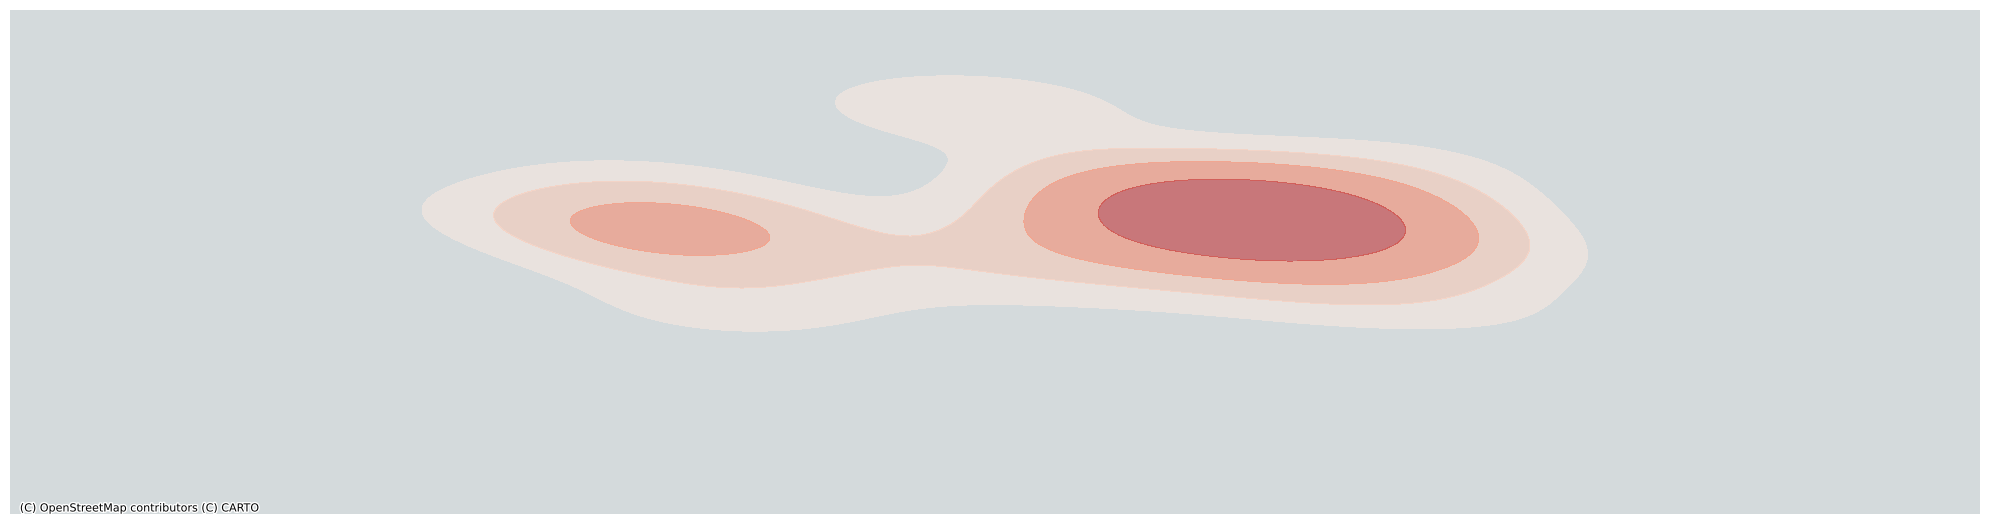

In [13]:
# create thresholds
levels = [0.2, 0.4, 0.6, 0.8, 1.0]
# create plot
f, ax = plt.subplots(ncols=1, figsize=(20,8))

#Kernel DEsity Estimation
kde = sns.kdeplot(
    ax = ax,
    x = gdf['geometry'].x,
    y = gdf['geometry'].y,
    levels = levels,
    shade = True,
    cmap = 'Reds',
    alpha = 0.5
)

#Add the basemap
ctx.add_basemap(ax=ax, source = ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.tight_layout()

plt.show()